# V&V anemia screening and iron interventions

This notebook focuses on anemia screening, oral iron, and IV iron.

All the separate checks in this notebok are labeled with "CHECK" (all caps).

## Setup

In [1]:
import pandas as pd, numpy as np, os
from vivarium import Artifact
import db_queries
from get_draws.api import get_draws
import matplotlib.pyplot as plt
from pathlib import Path
import yaml

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning) 

In [3]:
locations = ['Pakistan', 'Ethiopia', 'Nigeria']

In [4]:
# Parameters cell for papermill
model_dir = "model27.1"

In [5]:
# Parameters
model_dir = "model27.1"


In [6]:
base_results_dir = Path("/mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/results/") / model_dir

In [7]:
results_dirs = {}
assert set([p.stem for p in base_results_dir.iterdir()]) == set([l.lower() for l in locations])
for location in locations:
    location_dir = base_results_dir / location.lower()
    timestamps = sorted(location_dir.iterdir())
    last_timestamp = timestamps[-1]
    if len(timestamps) > 1:
        print(f'Multiple timestamps: {timestamps}, using {last_timestamp}')
    results_dirs[location] = location_dir / last_timestamp / 'results'

results_dirs

{'Pakistan': PosixPath('/mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/results/model27.1/pakistan/2026_01_22_10_05_21/results'),
 'Ethiopia': PosixPath('/mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/results/model27.1/ethiopia/2026_01_22_09_55_33/results'),
 'Nigeria': PosixPath('/mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/results/model27.1/nigeria/2026_01_22_10_01_54/results')}

In [8]:
location_ids = db_queries.get_ids('location')
location_ids = location_ids.loc[location_ids.location_name.str.lower().isin([x.lower() for x in results_dirs.keys()])]
location_ids

,location_id,location_name,location_type,location_description
139,165,Pakistan,admin0,admin0
150,179,Ethiopia,admin0,admin0
183,214,Nigeria,admin0,admin0


In [9]:
def load_yaml_file(path):
    with open(path) as stream:
        return yaml.safe_load(stream)

In [10]:
artifact_paths = {
    location: load_yaml_file(result_dir.parent / 'model_specification.yaml')['configuration']['input_data']['artifact_path']
    for location, result_dir
    in results_dirs.items()
}
artifact_paths

{'Pakistan': '/mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model27.1/pakistan.hdf',
 'Ethiopia': '/mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model27.1/ethiopia.hdf',
 'Nigeria': '/mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model27.1/nigeria.hdf'}

In [11]:
def read_results(result_file_name, baseline_only=True):
    all_locations_results = []
    for location, result_dir in results_dirs.items():
        if baseline_only:
           filters = [('scenario', '==', 'baseline')]
           location_results = pd.read_parquet(result_dir / f'{result_file_name}.parquet', filters=filters)
        else:
            location_results = pd.read_parquet(result_dir / f'{result_file_name}.parquet')
        location_results['location'] = location

        if baseline_only:
            location_results = location_results.loc[location_results.scenario == 'baseline']
        # note! I am running into issues if I do not drop these extra columns
        location_results = location_results.drop(columns=['measure','entity_type','entity','sub_entity'])
        if 'random_seed' in location_results.columns:
            location_results = location_results.drop(columns='random_seed').groupby([
                c for c in location_results.columns if c != 'random_seed' and c != 'value'
            ]).sum().reset_index()

        all_locations_results.append(location_results)
    return pd.concat(all_locations_results, ignore_index=True)

In [12]:
result_file_name = 'anc_hemoglobin'
anc = read_results(result_file_name, baseline_only=False)
anc.head()

,age_group,anc_coverage,ferritin_status,iv_iron_coverage,oral_iron_coverage,pregnancy_outcome,preterm_birth,tested_hemoglobin_exposure,true_hemoglobin_exposure,scenario,input_draw,location,value
0,10_to_14,first_trimester_and_later_pregnancy,adequate,covered,ifa,live_birth,False,adequate,adequate,anemia_screening_and_iv_iron_scaleup,22,Pakistan,0.0
1,10_to_14,first_trimester_and_later_pregnancy,adequate,covered,ifa,live_birth,False,adequate,adequate,anemia_screening_and_iv_iron_scaleup,60,Pakistan,0.0
2,10_to_14,first_trimester_and_later_pregnancy,adequate,covered,ifa,live_birth,False,adequate,adequate,anemia_screening_and_iv_iron_scaleup,71,Pakistan,0.0
3,10_to_14,first_trimester_and_later_pregnancy,adequate,covered,ifa,live_birth,False,adequate,adequate,anemia_screening_and_iv_iron_scaleup,79,Pakistan,0.0
4,10_to_14,first_trimester_and_later_pregnancy,adequate,covered,ifa,live_birth,False,adequate,adequate,anemia_screening_and_iv_iron_scaleup,115,Pakistan,0.0


In [13]:
scenarios_run = list(anc.scenario.unique())
assert 'baseline' in scenarios_run
scenarios_run

['anemia_screening_and_iv_iron_scaleup', 'baseline']

## checks on anemia screening

### hemoglobin

CHECK: Hemoglobin screening/testing only occurs among those who attend later-pregnancy ANC.

Type: precise assert.

In [14]:
assert anc.loc[(anc.anc_coverage.isin(['none', 'first_trimester_only']))
    & (anc.tested_hemoglobin_exposure != 'not_tested')]['value'].sum() == 0, 'hemoglobin screening among those without later pregnancy ANC coverage'

In [15]:
# https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/mncnh_pregnancy/anemia_screening.html#baseline-coverage-data
hemoglobin_screening_coverage_targets = pd.read_csv(
    '/snfs1/Project/simulation_science/mnch_grant/MNCNH portfolio/anc_bloodsample_prop_st-gpr_results_aggregates_scaled2025-05-29.csv'
)
assert (hemoglobin_screening_coverage_targets.age_group_id == 22).all()
assert (hemoglobin_screening_coverage_targets.sex_id == 3).all()
hemoglobin_screening_coverage_targets = hemoglobin_screening_coverage_targets[
    hemoglobin_screening_coverage_targets.location_id.isin(list(location_ids.location_id.values)) &
    (hemoglobin_screening_coverage_targets.year_id == 2023)
].merge(location_ids[['location_name', 'location_id']].rename(columns={'location_name': 'location'})).set_index('location')['mean']
hemoglobin_screening_coverage_targets.sort_index()

location
Ethiopia    0.629463
Nigeria     0.861348
Pakistan    0.797765
Name: mean, dtype: float64

In [16]:
tested_hemoglobin_exposure_by_scenario = (
    anc.loc[anc.anc_coverage.isin(['first_trimester_and_later_pregnancy', 'later_pregnancy_only'])].groupby(['location','scenario','tested_hemoglobin_exposure'])['value'].sum() 
    / anc.loc[anc.anc_coverage.isin(['first_trimester_and_later_pregnancy', 'later_pregnancy_only'])].groupby(['location','scenario'])['value'].sum()
)
tested_hemoglobin_exposure_by_scenario

# not easy to validate the proportion low vs adequate?
    # it's a measure of true hemoglobin exposure, but with testing error introduced via sensitivity and specificity of the test
    # the hemoglobin exposure at the time of measurement is also a little odd in that it is:
        # after the effect of oral iron at the first trimester ANC visit has been applied
        # and before the effect of oral iron not received until later pregnancy is applied
        # this means that we will overestimate the prevalence of anemia at this timepoint relative to the baseline GBD estimate

location  scenario                              tested_hemoglobin_exposure
Ethiopia  anemia_screening_and_iv_iron_scaleup  adequate                      0.688262
                                                low                           0.311738
                                                not_tested                    0.000000
          baseline                              adequate                      0.432911
                                                low                           0.196676
                                                not_tested                    0.370413
Nigeria   anemia_screening_and_iv_iron_scaleup  adequate                      0.569818
                                                low                           0.430182
                                                not_tested                    0.000000
          baseline                              adequate                      0.491891
                                                low    

CHECK: Hemoglobin screening/testing in the baseline scenario matches documented targets (see 2 cells above).

Type: fuzzy proportion check, though might need a bit of "fudge factor" for our limited number of parameter uncertainty draws.

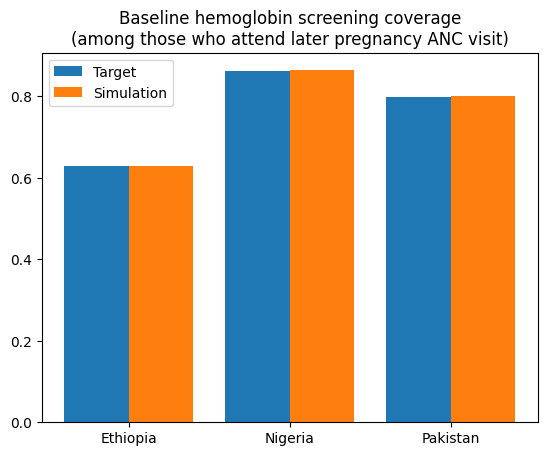

In [17]:
hemoglobin_screening_coverage = 1 - tested_hemoglobin_exposure_by_scenario.loc[(slice(None), 'baseline', 'not_tested')].sort_index()

width = 0.4
plt.bar(hemoglobin_screening_coverage.index, hemoglobin_screening_coverage_targets.sort_index(), width=width, label='Target')
plt.bar([x + 0.4 for x in range(len(hemoglobin_screening_coverage))], hemoglobin_screening_coverage, width=width, label='Simulation')
plt.xticks([x + width/2 for x in range(len(hemoglobin_screening_coverage))], hemoglobin_screening_coverage.index.get_level_values('location'), label='')
plt.title('Baseline hemoglobin screening coverage\n(among those who attend later pregnancy ANC visit)')
plt.legend()

# Coverage is inverted!

In [18]:
anemia_screening_scaleup_scenarios = []

for scenario in ['anemia_screening_vv', 'anemia_screening_and_iv_iron_scaleup']:
    if scenario in scenarios_run:
        anemia_screening_scaleup_scenarios.append(scenario)
    else:
        print(f'{scenario} not tested')

anemia_screening_scaleup_scenarios

anemia_screening_vv not tested


['anemia_screening_and_iv_iron_scaleup']

In [19]:
# Coverage is inverted!
# TODO: add a plot
tested_hemoglobin_exposure_by_scenario.loc[(slice(None), 'baseline', 'not_tested')].sort_index()

location
Ethiopia    0.370413
Nigeria     0.136668
Pakistan    0.199824
Name: value, dtype: float64

In [20]:
anemia_screening_scaleup_scenarios = list(set(scenarios_run) & {'anemia_screening_vv', 'anemia_screening_and_iv_iron_scaleup'})
anemia_screening_scaleup_scenarios

['anemia_screening_and_iv_iron_scaleup']

CHECK: Hemoglobin screening/testing in the anemia screening scaleup scenarios is 100%.

Type: precise assert.

In [21]:
for scenario in anemia_screening_scaleup_scenarios:
    assert (tested_hemoglobin_exposure_by_scenario.loc[(slice(None), scenario, 'not_tested')] == 0).all(), "not everyone tested in anemia screening scaleup scenario"

In [22]:
tested_hemoglobin_exposure_by_scenario.loc[('Ethiopia', slice(None), 'not_tested')].sort_values()

scenario
anemia_screening_and_iv_iron_scaleup    0.000000
baseline                                0.370413
Name: value, dtype: float64

CHECK: Hemoglobin screening/testing coverage does not differ between scenarios, except scenarios that scale it up.

Type: precise assert (due to CRN).

In [23]:
assert (tested_hemoglobin_exposure_by_scenario[
    (tested_hemoglobin_exposure_by_scenario.index.get_level_values('tested_hemoglobin_exposure') == 'not_tested') &
    (tested_hemoglobin_exposure_by_scenario.index.get_level_values('scenario').isin(anemia_screening_scaleup_scenarios)) # TODO: exclude other scenarios expected to scale up screening
].groupby('location').nunique() == 1).all(), "anemia screening coverage differs between scenarios that shouldn't affect it"

CHECK: The amount of tested "low" hemoglobin is less in scenarios that scale up MMS relative to those that don't (and don't change anemia screening coverage).

Type: precise assert (due to CRN).

In [24]:
if 'mms_total_scaleup' in scenarios_run:
    assert (
        tested_hemoglobin_exposure_by_scenario.loc[(slice(None), "mms_total_scaleup", "low")]
        <
        tested_hemoglobin_exposure_by_scenario.loc[(slice(None), "baseline", "low")]
    ).all(), "not seeing decreases in testing low in MMS scale-up scenario"
else:
    print('not tested')

not tested


In [25]:
true_hemoglobin_exposure_by_scenario = (
    anc.loc[anc.anc_coverage!='none'].groupby(['location','scenario','true_hemoglobin_exposure'])['value'].sum() 
    / anc.loc[anc.anc_coverage!='none'].groupby(['location','scenario'])['value'].sum()
)
true_hemoglobin_exposure_by_scenario

location  scenario                              true_hemoglobin_exposure
Ethiopia  anemia_screening_and_iv_iron_scaleup  adequate                    0.837363
                                                low                         0.162637
          baseline                              adequate                    0.837363
                                                low                         0.162637
Nigeria   anemia_screening_and_iv_iron_scaleup  adequate                    0.668113
                                                low                         0.331887
          baseline                              adequate                    0.668113
                                                low                         0.331887
Pakistan  anemia_screening_and_iv_iron_scaleup  adequate                    0.723376
                                                low                         0.276624
          baseline                              adequate                    0

CHECK: Proportion truly low hemoglobin (<100) is a bit higher in the baseline scenario than in GBD results.

Type: manual, since we have a known difference (having not applied all baseline IFA effects). Could consider observing something different so we could check this exactly.

In [26]:
from db_queries import get_outputs

# Get targets from the GBD estimates of the anemia impairment in pregnancy
# NOTE: pregnancy-specific GBD estimates are only available at the mean-UI, not draw, level
get_outputs(
    location_id=list(location_ids.location_id),
    topic='rei',
    rei_id=432, # rei_id=432 for moderate and severe anemia combined, which corresponds to our 'low' hemoglobin threshold of 100
    population_group_id=16, # pregnant population
    sex_id=2, # female
    year_id=2023,
    release_id=16, # GBD 2023
    # https://hub.ihme.washington.edu/spaces/GBDdirectory/pages/229280352/GBD+2023+EPIC+COMO+tracking
    # Latest COMO run (as of 12/2/2025) that included the pregnant population
    compare_version_id=8333,
    measure_id=5, # prevalence
    metric_id=3, # rate
    age_group_id=169, # 10-54 years
).set_index('location_name')[['val', 'lower', 'upper']].sort_index().join(
    true_hemoglobin_exposure_by_scenario.loc[(slice(None), 'baseline', 'low')].rename('sim')
)

# Looks reasonable, `sim` is pretty close to `val`, and we expect a slight overestimate from
# not fully applying baseline IFA yet.
    # we could follow up on this in the interactive sim where we could assess severity-specific prevalence after all baseline IFA effects have been applied

/mnt/share/homes/zmbc/mambaforge/envs/vivarium_gates_mncnh_artifact/lib/python3.11/site-packages/db_queries/legacy/get_outputs_helpers/formatting.py:272: UserWarning: When looking for rei_names, we are missing values given rei_set_id: 1. Filling with latest names from rei db table. WARNING: Be very careful if sharing these results with collaborators!!
  warnings.warn(


,val,lower,upper,sim
location_name,,,,
Ethiopia,0.144070,0.096123,0.203853,0.162637
Nigeria,0.294429,0.228368,0.356361,0.331887
Pakistan,0.231711,0.138710,0.314796,0.276624


CHECK: Proportion truly low hemoglobin (<100) is the same by scenarios that only differ on screening.

Type: precise assert (due to CRN).

In [27]:
if 'anemia_screening_vv' in scenarios_run:
    assert (
        true_hemoglobin_exposure_by_scenario.loc[(slice(None), 'anemia_screening_vv')]
        ==
        true_hemoglobin_exposure_by_scenario.loc[(slice(None), 'baseline')]
    ).all(), "Anemia screening scaleup modified true hemoglobin"
else:
    print('not tested')

not tested


CHECK: Proportion truly low hemoglobin (<100) is lower in scenarios that scale up MMS.

Type: precise assert (due to CRN).

In [28]:
if 'mms_total_scaleup' in scenarios_run:
    assert (
        true_hemoglobin_exposure_by_scenario.loc[(slice(None), 'mms_total_scaleup', 'low')]
        <
        true_hemoglobin_exposure_by_scenario.loc[(slice(None), 'baseline', 'low')]
    ).all(), "MMS did not decrease the amount of low hemoglobin"
else:
    print('not tested')

not tested


In [29]:
# let's check sensitivity and specificity for the hemoglobin screen

tested_hemoglobin_exposure_by_true_hemoglobin_exposure = (
    anc.loc[anc.tested_hemoglobin_exposure!='not_tested'].groupby(['location', 'scenario', 'true_hemoglobin_exposure','tested_hemoglobin_exposure'])['value'].sum() 
    / anc.loc[anc.tested_hemoglobin_exposure!='not_tested'].groupby(['location', 'scenario', 'true_hemoglobin_exposure'])['value'].sum()
)
tested_hemoglobin_exposure_by_true_hemoglobin_exposure

location  scenario                              true_hemoglobin_exposure  tested_hemoglobin_exposure
Ethiopia  anemia_screening_and_iv_iron_scaleup  adequate                  adequate                      0.799831
                                                                          low                           0.200169
                                                                          not_tested                    0.000000
                                                low                       adequate                      0.149367
                                                                          low                           0.850633
                                                                          not_tested                    0.000000
          baseline                              adequate                  adequate                      0.799361
                                                                          low                           0.20

CHECK: Proportion truly adequate hemoglobin (>=100) who *test* adequate is approximately 80%, in all scenarios and locations.

Type: fuzzy check of proportion. Would also like to include a check that aggregates across locations here.

In [30]:
# https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/mncnh_pregnancy/anemia_screening.html#hemoglobin-screening-accuracy-instructions
# Specificity (percent of true negatives that test negative): 80%

tested_hemoglobin_exposure_by_true_hemoglobin_exposure.loc[(slice(None), slice(None), 'adequate', 'adequate')]

# Looks good

location  scenario                            
Ethiopia  anemia_screening_and_iv_iron_scaleup    0.799831
          baseline                                0.799361
Nigeria   anemia_screening_and_iv_iron_scaleup    0.801287
          baseline                                0.801206
Pakistan  anemia_screening_and_iv_iron_scaleup    0.799787
          baseline                                0.799770
Name: value, dtype: float64

CHECK: Proportion truly low hemoglobin (<100) who *test* low is approximately 85%, in all scenarios and locations.

Type: fuzzy check of proportion. Would also like to include a check that aggregates across locations here.

In [31]:
# Sensitivity (percent of true positives that test positive): 85%
# a little confusing, but positive test result refers to low hemoglobin screening value
tested_hemoglobin_exposure_by_true_hemoglobin_exposure.loc[(slice(None), slice(None), 'low', 'low')]

# Looks good

location  scenario                            
Ethiopia  anemia_screening_and_iv_iron_scaleup    0.850633
          baseline                                0.851967
Nigeria   anemia_screening_and_iv_iron_scaleup    0.849083
          baseline                                0.849026
Pakistan  anemia_screening_and_iv_iron_scaleup    0.850050
          baseline                                0.849839
Name: value, dtype: float64

### ferritin

CHECK: Ferritin screening only occurs in anemia screening scaleup scenarios.

Type: precise assert.

In [32]:
assert anc.loc[(~anc.scenario.isin(anemia_screening_scaleup_scenarios)) 
    & (anc.ferritin_status!='not_tested')]['value'].sum() == 0, "Non-zero ferritin screening coverage outside of anemia screening scale up scenarios"

CHECK: Ferritin screening only occurs in simulants who go to later-pregnancy ANC.

Type: precise assert.

In [33]:
assert anc.loc[(anc.anc_coverage.isin(['none', 'first_trimester_only']))
    & (anc.ferritin_status != 'not_tested')]['value'].sum() == 0, 'ferritin screening among those without later pregnancy ANC coverage'

CHECK: Ferritin screening only occurs in simulants who test low hemoglobin.

Type: precise assert.

In [34]:
assert anc.loc[(anc.ferritin_status != 'not_tested')
    & (anc.tested_hemoglobin_exposure != 'low')]['value'].sum() == 0, 'ferritin testing occuring among those who do not test low hemoglobin'

CHECK: Ferritin screening occurs in 100% of simulants who test low hemoglobin in the anemia screening scale-up scenarios.

Type: precise assert.

In [35]:
assert anc.loc[(anc.ferritin_status == 'not_tested')
    & (anc.scenario =='anemia_screening_vv')
    & (anc.tested_hemoglobin_exposure == 'low')]['value'].sum() == 0, 'ferritin testing not occuring among those who DO test low hemoglobin'

CHECK: The probability of low ferritin among those screened approximately matches the probability of low ferritin in the artifact.

Type: manual, since this check is pretty flawed; we can check it better in the interactive sim.

In [36]:
draws = [f'draw_{draw}' for draw in anc.input_draw.unique()]
probability_low_ferritin_targets = pd.concat([
    Artifact(path).load('ferritin.probability_of_low_ferritin').assign(location=location).set_index('location', append=True)
    for location, path in artifact_paths.items()
]).reorder_levels(['location', 'age_start', 'age_end', 'anemia_status_during_pregnancy']).T.describe(percentiles=[0.025, 0.975]).T
probability_low_ferritin_targets

count      mean  \
location age_start age_end anemia_status_during_pregnancy                    
Pakistan 10.0      15.0    mild                            250.0  0.938705   
                           moderate                        250.0  0.900266   
                           not_anemic                      250.0  0.469352   
                           severe                          250.0  0.879050   
         15.0      20.0    mild                            250.0  0.894441   
...                                                          ...       ...   
Nigeria  45.0      50.0    severe                          250.0  0.658600   
         50.0      55.0    mild                            250.0  0.815587   
                           moderate                        250.0  0.699120   
                           not_anemic                      250.0  0.407794   
                           severe                          250.0  0.666498   

                                                                std       min  \
location age_start age_end anemia_status_during_pregnancy                       
Pakistan 10.0      15.0    mild                            0.011342  0.895233   
                           moderate                        0.029630  0.735936   
                           not_anemic                      0.005671  0.447616   
                           severe                          0.018505  0.808862   
         15.0      20.0    mild                            0.012234  0.847862   
...                                                             ...       ...   
Nigeria  45.0      50.0    severe                          0.037266  0.567642   
         50.0      55.0    mild                            0.041919  0.581256   
                           moderate                        0.080072  0.462742   
                           not_anemic                      0.020960  0.290628   
                           severe                          0.047446  0.562384   

                                                               2.5%       50%  \
location age_start age_end anemia_status_during_pregnancy                       
Pakistan 10.0      15.0    mild                            0.913105  0.940630   
                           moderate                        0.822237  0.908993   
                           not_anemic                      0.456552  0.470315   
                           severe                          0.842101  0.880386   
         15.0      20.0    mild                            0.865017  0.896793   
...                                                             ...       ...   
Nigeria  45.0      50.0    severe                          0.581783  0.656905   
         50.0      55.0    mild                            0.724914  0.823817   
                           moderate                        0.517966  0.714783   
                           not_anemic                      0.362457  0.411908   
                           severe                          0.575091  0.668571   

                                                              97.5%       max  
location age_start age_end anemia_status_during_pregnancy                      
Pakistan 10.0      15.0    mild                            0.960426  0.963354  
                           moderate                        0.933968  0.937613  
                           not_anemic                      0.480213  0.481677  
                           severe                          0.910061  0.917687  
         15.0      20.0    mild                            0.910636  0.922424  
...                                                             ...       ...  
Nigeria  45.0      50.0    severe                          0.731293  0.739107  
         50.0      55.0    mild                            0.871533  0.909352  
                           moderate                        0.818526  0.828263  
                           not_anemic                   

In [37]:
probability_low_ferritin_targets['age_group'] = (
    probability_low_ferritin_targets.index.get_level_values('age_start').astype(int).astype(str)
    + '_to_'
    + (probability_low_ferritin_targets.index.get_level_values('age_end').astype(int) - 1).astype(str)
)

probability_low_ferritin_targets = probability_low_ferritin_targets.droplevel(['age_start', 'age_end']).set_index('age_group', append=True)
probability_low_ferritin_targets

count      mean       std  \
location anemia_status_during_pregnancy age_group                              
Pakistan mild                           10_to_14   250.0  0.938705  0.011342   
         moderate                       10_to_14   250.0  0.900266  0.029630   
         not_anemic                     10_to_14   250.0  0.469352  0.005671   
         severe                         10_to_14   250.0  0.879050  0.018505   
         mild                           15_to_19   250.0  0.894441  0.012234   
...                                                  ...       ...       ...   
Nigeria  severe                         45_to_49   250.0  0.658600  0.037266   
         mild                           50_to_54   250.0  0.815587  0.041919   
         moderate                       50_to_54   250.0  0.699120  0.080072   
         not_anemic                     50_to_54   250.0  0.407794  0.020960   
         severe                         50_to_54   250.0  0.666498  0.047446   

                                                        min      2.5%  \
location anemia_status_during_pregnancy age_group                       
Pakistan mild                           10_to_14   0.895233  0.913105   
         moderate                       10_to_14   0.735936  0.822237   
         not_anemic                     10_to_14   0.447616  0.456552   
         severe                         10_to_14   0.808862  0.842101   
         mild                           15_to_19   0.847862  0.865017   
...                                                     ...       ...   
Nigeria  severe                         45_to_49   0.567642  0.581783   
         mild                           50_to_54   0.581256  0.724914   
         moderate                       50_to_54   0.462742  0.517966   
         not_anemic                     50_to_54   0.290628  0.362457   
         severe                         50_to_54   0.562384  0.575091   

                                                        50%     97.5%  \
location anemia_status_during_pregnancy age_group                       
Pakistan mild                           10_to_14   0.940630  0.960426   
         moderate                       10_to_14   0.908993  0.933968   
         not_anemic                     10_to_14   0.470315  0.480213   
         severe                         10_to_14   0.880386  0.910061   
         mild                           15_to_19   0.896793  0.910636   
...                                                     ...       ...   
Nigeria  severe                         45_to_49   0.656905  0.731293   
         mild                           50_to_54   0.823817  0.871533   
         moderate                       50_to_54   0.714783  0.818526   
         not_anemic                     50_to_54   0.411908  0.435767   
         severe                         50_to_54   0.668571  0.757759   

                                                        max  
location anemia_status_during_pregnancy age_group            
Pakistan mild                           10_to_14   0.963354  
         moderate                       10_to_14   0.937613  
         not_anemic                     10_to_14   0.481677  
         severe                         10_to_14   0.917687  
         mild                           15_to_19   0.922424  
...                                                     ...  
Nigeria  severe                         45_to_49   0.739107  
         mild                           50_to_54   0.909352  
         moderate                       50_to_54   0.828263  
         not_anemic                     50_to_54   0.454676  
         severe                         50_to_54   0.767808  

[108 rows x 8 columns]

In [38]:
means_by_category = probability_low_ferritin_targets['mean'].unstack('anemia_status_during_pregnancy')
# We have to map low/adequate to the anemia categories, which is not exact and makes this all a bit handwavey;
# the value we observe from the sim will be some weighted mix of these two "bounds"
probability_low_ferritin_targets = pd.concat([
    # 'low' corresponds to below 100, which means moderate or severe
    means_by_category[['moderate', 'severe']].rename(columns={'moderate': 'bound1', 'severe': 'bound2'})
        .assign(true_hemoglobin_exposure='low')
        .set_index('true_hemoglobin_exposure', append=True),
    # 'adequate' corresponds to above 100, which means mild or not_anemic
    means_by_category[['mild', 'not_anemic']].rename(columns={'not_anemic': 'bound1', 'mild': 'bound2'})
        .assign(true_hemoglobin_exposure='adequate')
        .set_index('true_hemoglobin_exposure', append=True),
])
probability_low_ferritin_targets

anemia_status_during_pregnancy                 bound1    bound2
location age_group true_hemoglobin_exposure                    
Ethiopia 10_to_14  low                       0.710322  0.641149
         15_to_19  low                       0.669580  0.644903
         20_to_24  low                       0.685428  0.649065
         25_to_29  low                       0.681194  0.641526
         30_to_34  low                       0.696452  0.644095
         35_to_39  low                       0.703279  0.643632
         40_to_44  low                       0.661846  0.621613
         45_to_49  low                       0.674925  0.632734
         50_to_54  low                       0.698701  0.649603
Nigeria  10_to_14  low                       0.699062  0.646273
         15_to_19  low                       0.697927  0.647912
         20_to_24  low                       0.721707  0.670437
         25_to_29  low                       0.710926  0.662829
         30_to_34  low                       0.716497  0.663598
         35_to_39  low                       0.694597  0.648507
         40_to_44  low                       0.688663  0.643697
         45_to_49  low                       0.684452  0.658600
         50_to_54  low                       0.699120  0.666498
Pakistan 10_to_14  low                       0.900266  0.879050
         15_to_19  low                       0.854160  0.840061
         20_to_24  low                       0.844060  0.836409
         25_to_29  low                       0.846117  0.838762
         30_to_34  low                       0.847559  0.841024
         35_to_39  low                       0.851646  0.844255
         40_to_44  low                       0.851287  0.842165
         45_to_49  low                       0.849862  0.840028
         50_to_54  low                       0.861107  0.848223
Ethiopia 10_to_14  adequate                  0.433987  0.867973
         15_to_19  adequate                  0.397161  0.794323
         20_to_24  adequate                  0.405180  0.810361
         25_to_29  adequate                  0.404420  0.808840
         30_to_34  adequate                  0.408874  0.817749
         35_to_39  adequate                  0.411447  0.822894
         40_to_44  adequate                  0.398233  0.796467
         45_to_49  adequate                  0.400904  0.801808
         50_to_54  adequate                  0.410667  0.821334
Nigeria  10_to_14  adequate                  0.430573  0.861146
         15_to_19  adequate                  0.418656  0.837313
         20_to_24  adequate                  0.421916  0.843833
         25_to_29  adequate                  0.415141  0.830282
         30_to_34  adequate                  0.418743  0.837486
         35_to_39  adequate                  0.416456  0.832912
         40_to_44  adequate                  0.414531  0.829061
         45_to_49  adequate                  0.404797  0.809594
         50_to_54  adequate                  0.407794  0.815587
Pakistan 10_to_14  adequate                  0.469352  0.938705
         15_to_19  adequate                  0.447221  0.894441
         20_to_24  adequate                  0.443532  0.887063
         25_to_29  adequate                  0.443968  0.887937
         30_to_34  adequate                  0.443687  0.887374
         35_to_39  adequate                  0.445089  0.890179
         40_to_44  adequate                  0.446002  0.892004
         45_to_49  adequate                  0.445825  0.891650
         50_to_54  adequate                  0.449120  0.898240

In [39]:
ferritin_results_by_scenario = (
    anc.loc[anc.scenario.isin(anemia_screening_scaleup_scenarios) & (anc.ferritin_status == 'low')].groupby(['scenario', 'location', 'age_group', 'true_hemoglobin_exposure'])['value'].sum()
    /
    anc.loc[anc.scenario.isin(anemia_screening_scaleup_scenarios) & (anc.ferritin_status != 'not_tested')].groupby(['scenario', 'location', 'age_group', 'true_hemoglobin_exposure'])['value'].sum()
).dropna()
ferritin_results_by_scenario

scenario                              location  age_group  true_hemoglobin_exposure
anemia_screening_and_iv_iron_scaleup  Ethiopia  10_to_14   adequate                    0.543860
                                                           low                         0.692533
                                                15_to_19   adequate                    0.473752
                                                           low                         0.674692
                                                20_to_24   adequate                    0.485990
                                                           low                         0.675827
                                                25_to_29   adequate                    0.480839
                                                           low                         0.667599
                                                30_to_34   adequate                    0.486693
                                                    

In [40]:
assert (ferritin_results_by_scenario.groupby([c for c in ferritin_results_by_scenario.index.names if c != 'scenario']).nunique() == 1).all(), "ferritin results differ between scaleup scenarios"

ferritin_results = ferritin_results_by_scenario.groupby([c for c in ferritin_results_by_scenario.index.names if c != 'scenario']).first()
ferritin_results

location  age_group  true_hemoglobin_exposure
Ethiopia  10_to_14   adequate                    0.543860
                     low                         0.692533
          15_to_19   adequate                    0.473752
                     low                         0.674692
          20_to_24   adequate                    0.485990
                     low                         0.675827
          25_to_29   adequate                    0.480839
                     low                         0.667599
          30_to_34   adequate                    0.486693
                     low                         0.670793
          35_to_39   adequate                    0.493941
                     low                         0.669572
          40_to_44   adequate                    0.476345
                     low                         0.631102
          45_to_49   adequate                    0.492063
                     low                         0.697343
          50_to_54   adequ

In [41]:
comparison = ferritin_results.rename('sim').to_frame().join(probability_low_ferritin_targets.reorder_levels(ferritin_results.index.names))
comparison

# Looks reasonable

sim    bound1    bound2
location age_group true_hemoglobin_exposure                              
Ethiopia 10_to_14  adequate                  0.543860  0.433987  0.867973
                   low                       0.692533  0.710322  0.641149
         15_to_19  adequate                  0.473752  0.397161  0.794323
                   low                       0.674692  0.669580  0.644903
         20_to_24  adequate                  0.485990  0.405180  0.810361
                   low                       0.675827  0.685428  0.649065
         25_to_29  adequate                  0.480839  0.404420  0.808840
                   low                       0.667599  0.681194  0.641526
         30_to_34  adequate                  0.486693  0.408874  0.817749
                   low                       0.670793  0.696452  0.644095
         35_to_39  adequate                  0.493941  0.411447  0.822894
                   low                       0.669572  0.703279  0.643632
         40_to_44  adequate                  0.476345  0.398233  0.796467
                   low                       0.631102  0.661846  0.621613
         45_to_49  adequate                  0.492063  0.400904  0.801808
                   low                       0.697343  0.674925  0.632734
         50_to_54  adequate                  0.493671  0.410667  0.821334
                   low                       0.660714  0.698701  0.649603
Nigeria  10_to_14  adequate                  0.624060  0.430573  0.861146
                   low                       0.692334  0.699062  0.646273
         15_to_19  adequate                  0.604136  0.418656  0.837313
                   low                       0.703262  0.697927  0.647912
         20_to_24  adequate                  0.593465  0.421916  0.843833
                   low                       0.729612  0.721707  0.670437
         25_to_29  adequate                  0.580968  0.415141  0.830282
                   low                       0.718042  0.710926  0.662829
         30_to_34  adequate                  0.596430  0.418743  0.837486
                   low                       0.724259  0.716497  0.663598
         35_to_39  adequate                  0.593032  0.416456  0.832912
                   low                       0.705987  0.694597  0.648507
         40_to_44  adequate                  0.608942  0.414531  0.829061
                   low                       0.704375  0.688663  0.643697
         45_to_49  adequate                  0.581544  0.404797  0.809594
                   low                       0.661957  0.684452  0.658600
         50_to_54  adequate                  0.494737  0.407794  0.815587
                   low                       0.706977  0.699120  0.666498
Pakistan 10_to_14  adequate                  0.594444  0.469352  0.938705
                   low                       0.902280  0.900266  0.879050
         15_to_19  adequate                  0.589652  0.447221  0.894441
                   low                       0.853265  0.854160  0.840061
         20_to_24  adequate                  0.584252  0.443532  0.887063
                   low                       0.840296  0.844060  0.836409
         25_to_29  adequate                  0.579817  0.443968  0.887937
                   low                       0.844444  0.846117  0.838762
         30_to_34  adequate                  0.576626  0.443687  0.887374
                   low                       0.843919  0.847559  0.841024
         35_to_39  adequate                  0.583759  0.445089  0.890179
                   low                       0.850743  0.851646  0.844255
         40_to_44  adequate                  0.586051  0.446002  0.892004
                   low                       0.848395  0.851287  0.842165
         45_to_49  adequate                  0.590146  0.445825  0.891650
                   low                       0.847980  0.849862  0.840028
         50_to_54  adequate                  0.644444 

In [42]:
# As we can see there are a few cases where the sim value is outside the bounds of the means, particularly in Nigeria (why?)

comparison[(comparison['sim'] >= comparison['bound1']) == (comparison['sim'] >= comparison['bound2'])]

sim    bound1    bound2
location age_group true_hemoglobin_exposure                              
Ethiopia 15_to_19  low                       0.674692  0.669580  0.644903
         45_to_49  low                       0.697343  0.674925  0.632734
Nigeria  15_to_19  low                       0.703262  0.697927  0.647912
         20_to_24  low                       0.729612  0.721707  0.670437
         25_to_29  low                       0.718042  0.710926  0.662829
         30_to_34  low                       0.724259  0.716497  0.663598
         35_to_39  low                       0.705987  0.694597  0.648507
         40_to_44  low                       0.704375  0.688663  0.643697
         50_to_54  low                       0.706977  0.699120  0.666498
Pakistan 10_to_14  low                       0.902280  0.900266  0.879050

## checks on iron intervention coverage

### oral iron

CHECK: Oral iron only received by simulants who attend ANC.

Type: precise assert.

In [43]:
assert anc.loc[(anc.anc_coverage=='none')
    & (anc.oral_iron_coverage != 'none')]['value'].sum() == 0, "coverage of oral iron among those who do not attend ANC"

CHECK: MMS only received in scenarios that scale it up.

Type: precise assert.

In [44]:
assert anc.loc[
    (anc.scenario != 'mms_total_scaleup') &
    (anc.oral_iron_coverage == 'mms')
]['value'].sum() == 0, "baseline MMS coverage"

CHECK: MMS received by every simulant who attends ANC in the scenarios that fully scale up MMS.

Type: precise assert.

In [45]:
assert anc.loc[
    (anc.scenario == 'mms_total_scaleup') &
    (anc.anc_coverage != 'none') &
    (anc.oral_iron_coverage != 'mms')
]['value'].sum() == 0, "MMS coverage not fully scaled up"

CHECK: IFA coverage is the same between baseline and anemia screening scenarios.

Type: precise assert (due to CRN).

In [46]:
if 'anemia_screening_vv' in scenarios_run:
    assert anc.loc[
        (anc.scenario == 'anemia_screening_vv') &
        (anc.oral_iron_coverage == 'ifa')
    ]['value'].sum() == anc.loc[
        (anc.scenario == 'baseline') &
        (anc.oral_iron_coverage == 'ifa')
    ]['value'].sum(), "IFA coverage changed in anemia screening scenario"
else:
    print('not tested')

not tested


In [47]:
# https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/mncnh_pregnancy/oral_iron_antenatal/oral_iron_antenatal.html#baseline-coverage-data
baseline_ifa_coverage_targets = pd.read_csv(
    '/snfs1/Project/simulation_science/mnch_grant/MNCNH portfolio/anc_iron_prop_st-gpr_results_aggregates_scaled2025-05-30.csv'
)
assert (baseline_ifa_coverage_targets.age_group_id == 22).all()
assert (baseline_ifa_coverage_targets.sex_id == 3).all()
baseline_ifa_coverage_targets = baseline_ifa_coverage_targets[
    baseline_ifa_coverage_targets.location_id.isin(list(location_ids.location_id.values)) &
    (baseline_ifa_coverage_targets.year_id == 2023)
].merge(location_ids[['location_name', 'location_id']].rename(columns={'location_name': 'location'})).set_index('location')['mean']
baseline_ifa_coverage_targets.sort_index()

location
Ethiopia    0.560457
Nigeria     0.834046
Pakistan    0.720089
Name: mean, dtype: float64

CHECK: IFA coverage in the baseline scenario matches documented targets.

Type: fuzzy proportion check, though might need a bit of "fudge factor" for our limited number of parameter uncertainty draws. Alternatively, could check vs artifact at the draw level.

In [48]:
(
    anc.loc[(anc.anc_coverage!='none') & (anc.scenario == 'baseline') & (anc.oral_iron_coverage == 'ifa')].groupby(['location', 'input_draw'])['value'].sum()
    /
    anc.loc[(anc.anc_coverage!='none') & (anc.scenario == 'baseline')].groupby(['location', 'input_draw'])['value'].sum()
).groupby('location').describe()

# IFA coverage looks very similar to the targets above

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
Ethiopia,10.0,0.554048,0.023422,0.531490,0.538630,0.550428,0.557680,0.613625
Nigeria,10.0,0.828853,0.013720,0.815025,0.820542,0.827315,0.831582,0.863318
Pakistan,10.0,0.716749,0.018491,0.687988,0.705969,0.721918,0.726726,0.749029


In [49]:
# Now checking the effects
# If we ran only the baseline scenario, we can still approximately (without CRN) check the IFA effect on birth outcomes (which is no effect)
# by comparing the groups, however we have to stratify by ANC to control for confounding by ANC
# this is because partial term pregnancies are less likely to go to ANC and therefore less likely to receive IFA
baseline_with_ifa_coverage = anc.loc[(anc.scenario=='baseline')].assign(ifa_coverage=lambda df: df.oral_iron_coverage == 'ifa')

cols = ['location']
baseline_pregnancy_outcome_proportions = (
    baseline_with_ifa_coverage.groupby(cols + ['anc_coverage', 'ifa_coverage', 'pregnancy_outcome'])['value'].sum() /
    baseline_with_ifa_coverage.groupby(cols + ['anc_coverage', 'ifa_coverage'])['value'].sum()
)
cross_simulant_comparison = (
    baseline_pregnancy_outcome_proportions.loc[(slice(None), slice(None), True, slice(None))] /
    baseline_pregnancy_outcome_proportions.loc[(slice(None), slice(None), False, slice(None))]
)
cross_simulant_comparison
# Should all be close to 1, which it is

location  anc_coverage                         pregnancy_outcome
Ethiopia  first_trimester_and_later_pregnancy  live_birth           0.999873
                                               partial_term              NaN
                                               stillbirth           1.003798
          first_trimester_only                 live_birth           0.995346
                                               partial_term         1.000331
                                               stillbirth           0.938853
          later_pregnancy_only                 live_birth           1.000439
                                               partial_term              NaN
                                               stillbirth           0.987041
          none                                 live_birth                NaN
                                               partial_term              NaN
                                               stillbirth                NaN
Nigeria   f

In [50]:
# NOTE: We don't have an IFA scale-up scenario to be able to do a cross-scenario comparison
(anc[anc.oral_iron_coverage == 'ifa'].groupby(['scenario'])['value'].sum() / anc.groupby(['scenario'])['value'].sum()).sort_values()

scenario
anemia_screening_and_iv_iron_scaleup    0.481331
baseline                                0.481331
Name: value, dtype: float64

In [51]:
scenario_pregnancy_outcome_proportions = (
    anc.groupby(cols + ['scenario', 'pregnancy_outcome'])['value'].sum()
     / anc.groupby(cols + ['scenario'])['value'].sum()
)
scenario_pregnancy_outcome_proportions

location  scenario                              pregnancy_outcome
Ethiopia  anemia_screening_and_iv_iron_scaleup  live_birth           0.536036
                                                partial_term         0.445817
                                                stillbirth           0.018146
          baseline                              live_birth           0.536343
                                                partial_term         0.445817
                                                stillbirth           0.017839
Nigeria   anemia_screening_and_iv_iron_scaleup  live_birth           0.530558
                                                partial_term         0.450024
                                                stillbirth           0.019418
          baseline                              live_birth           0.531203
                                                partial_term         0.450024
                                                stillbirth           0.01877

In [52]:
cross_scenario_comparison = (
    scenario_pregnancy_outcome_proportions[scenario_pregnancy_outcome_proportions.index.get_level_values('scenario') != 'baseline'] /
    scenario_pregnancy_outcome_proportions.loc[(slice(None), 'baseline', slice(None))]
)
cross_scenario_comparison

location  pregnancy_outcome  scenario                            
Ethiopia  live_birth         anemia_screening_and_iv_iron_scaleup    0.999427
          partial_term       anemia_screening_and_iv_iron_scaleup    1.000000
          stillbirth         anemia_screening_and_iv_iron_scaleup    1.017238
Nigeria   live_birth         anemia_screening_and_iv_iron_scaleup    0.998787
          partial_term       anemia_screening_and_iv_iron_scaleup    1.000000
          stillbirth         anemia_screening_and_iv_iron_scaleup    1.034331
Pakistan  live_birth         anemia_screening_and_iv_iron_scaleup    0.997903
          partial_term       anemia_screening_and_iv_iron_scaleup    1.000000
          stillbirth         anemia_screening_and_iv_iron_scaleup    1.042686
Name: value, dtype: float64

In [53]:
# check IFA on PTB relative to no treatment
    # filter to single ANC category to control for confounding by ANC in the IFA->PTB effect
    # this is because ANC is correlated with IFA (IFA is distributed at ANC) and correlated with PTB (through the delivery choice model)
x = (anc.loc[(anc.preterm_birth==True) & (anc.scenario=='baseline') 
    & (anc.pregnancy_outcome=='live_birth')
    &(anc.anc_coverage=='first_trimester_and_later_pregnancy')].assign(ifa_coverage=lambda df: df.oral_iron_coverage == 'ifa').groupby(['location','input_draw','ifa_coverage'])['value'].sum()
 /anc.loc[(anc.scenario=='baseline') 
     & (anc.pregnancy_outcome=='live_birth')
     &(anc.anc_coverage=='first_trimester_and_later_pregnancy')].assign(ifa_coverage=lambda df: df.oral_iron_coverage == 'ifa').groupby(['location','input_draw','ifa_coverage'])['value'].sum())
x_no_tx = x.reset_index().loc[~x.index.get_level_values('ifa_coverage')].set_index(['location','input_draw'])['value']
rr = (x / x_no_tx).reset_index()
rr.groupby(['ifa_coverage'])['value'].describe(percentiles=[0.025,0.975]).reset_index()

# we expect this to be 0.9 (95% CI: 0.86, 0.95) based on: https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/mncnh_pregnancy/oral_iron_antenatal/oral_iron_antenatal.html#id29
# well values are no longer 1, so that's an improvement! 

# we do seem to be exaggerating the effect a bit though

,ifa_coverage,count,mean,std,min,2.5%,50%,97.5%,max
0,False,30.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.00000,1.000000
1,True,30.0,0.874021,0.033275,0.815936,0.817682,0.881847,0.92369,0.939111


In [54]:
# let's check by location
rr.loc[rr.ifa_coverage].groupby(['ifa_coverage','location'])['value'].describe(percentiles=[0.025,0.975]).reset_index()

# so we're much closer to our target in Pakistan than we are for Nigeria and Ethiopia
    # let's check and make sure that the IFA GA shifts we are using are location-specific as intended

,ifa_coverage,location,count,mean,std,min,2.5%,50%,97.5%,max
0,True,Ethiopia,10.0,0.873358,0.043017,0.818344,0.818579,0.887659,0.932601,0.939111
1,True,Nigeria,10.0,0.864590,0.033993,0.815936,0.816784,0.867980,0.912372,0.917840
2,True,Pakistan,10.0,0.884114,0.018688,0.859818,0.860179,0.884657,0.904316,0.904497


In [55]:
# now check MMS on PTB relative to IFA

x = (anc.loc[(anc.preterm_birth==True)
    &(anc.anc_coverage=='first_trimester_and_later_pregnancy')].groupby(['oral_iron_coverage','location','input_draw'])['value'].sum()
 /anc.loc[anc.anc_coverage=='first_trimester_and_later_pregnancy'].groupby(['oral_iron_coverage', 'location','input_draw'])['value'].sum())
x_ifa = x.loc['ifa']
rr = x / x_ifa
rr = rr.groupby(['oral_iron_coverage','location']).describe(percentiles=[0.025,0.975]).reset_index()
rr = rr.loc[rr.oral_iron_coverage == 'mms']
rr

# expect this to be RR = 0.91 (95% CI: 0.84, 0.99) based on research docs
# Looking good!
# our confidence interval is a bit tighter than our input data, but hopefully that improves as we increase the number of draws we run

,oral_iron_coverage,location,count,mean,std,min,2.5%,50%,97.5%,max
3,mms,Ethiopia,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mms,Nigeria,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,mms,Pakistan,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
# ok now let's check hemoglobin exposure by scenario

# TODO: name variable
x = (anc.loc[(anc.true_hemoglobin_exposure=='low')
    &(anc.anc_coverage=='first_trimester_and_later_pregnancy')
    ].groupby(['location','oral_iron_coverage'])['value'].sum()
 /anc.loc[anc.anc_coverage=='first_trimester_and_later_pregnancy'].groupby(['location','oral_iron_coverage'])['value'].sum()).fillna(0)

x

location  oral_iron_coverage
Ethiopia  ifa                   0.104463
          mms                   0.000000
          none                  0.204060
Nigeria   ifa                   0.232393
          mms                   0.000000
          none                  0.422150
Pakistan  ifa                   0.196525
          mms                   0.000000
          none                  0.366304
Name: value, dtype: float64

In [57]:
nn_deaths = read_results('neonatal_burden_observer_disorder_deaths', baseline_only=False)
nn_deaths.head()

,acs_availability,acs_eligibility,antibiotics_availability,child_age_group,child_sex,cpap_availability,delivery_facility_type,neonatal_burden_observer_cause_of_death,preterm_birth,probiotics_availability,scenario,input_draw,location,value
0,False,False,False,early_neonatal,Female,False,BEmONC,neonatal_encephalopathy_due_to_birth_asphyxia_...,False,False,anemia_screening_and_iv_iron_scaleup,22,Pakistan,237.0
1,False,False,False,early_neonatal,Female,False,BEmONC,neonatal_encephalopathy_due_to_birth_asphyxia_...,False,False,anemia_screening_and_iv_iron_scaleup,60,Pakistan,197.0
2,False,False,False,early_neonatal,Female,False,BEmONC,neonatal_encephalopathy_due_to_birth_asphyxia_...,False,False,anemia_screening_and_iv_iron_scaleup,71,Pakistan,225.0
3,False,False,False,early_neonatal,Female,False,BEmONC,neonatal_encephalopathy_due_to_birth_asphyxia_...,False,False,anemia_screening_and_iv_iron_scaleup,79,Pakistan,223.0
4,False,False,False,early_neonatal,Female,False,BEmONC,neonatal_encephalopathy_due_to_birth_asphyxia_...,False,False,anemia_screening_and_iv_iron_scaleup,115,Pakistan,134.0


In [58]:
deaths = read_results('maternal_disorders_burden_observer_disorder_deaths', baseline_only=False)
deaths.head()

,age_group,azithromycin_availability,delivery_facility_type,maternal_disorders_burden_observer_cause_of_death,misoprostol_availability,pregnancy_outcome,scenario,input_draw,location,value
0,10_to_14,False,BEmONC,abortion_miscarriage_ectopic_pregnancy,False,live_birth,anemia_screening_and_iv_iron_scaleup,22,Pakistan,0.0
1,10_to_14,False,BEmONC,abortion_miscarriage_ectopic_pregnancy,False,live_birth,anemia_screening_and_iv_iron_scaleup,60,Pakistan,0.0
2,10_to_14,False,BEmONC,abortion_miscarriage_ectopic_pregnancy,False,live_birth,anemia_screening_and_iv_iron_scaleup,71,Pakistan,0.0
3,10_to_14,False,BEmONC,abortion_miscarriage_ectopic_pregnancy,False,live_birth,anemia_screening_and_iv_iron_scaleup,79,Pakistan,0.0
4,10_to_14,False,BEmONC,abortion_miscarriage_ectopic_pregnancy,False,live_birth,anemia_screening_and_iv_iron_scaleup,115,Pakistan,0.0


In [59]:
mmr = (deaths.groupby(['location','scenario','input_draw'])['value'].sum()
       / anc.groupby(['location','scenario','input_draw'])['value'].sum()) * 100_000
mmr = mmr.groupby(['location','scenario']).mean()
mmr

# this looks reasonable

location  scenario                            
Ethiopia  anemia_screening_and_iv_iron_scaleup    159.9
          baseline                                162.0
Nigeria   anemia_screening_and_iv_iron_scaleup    186.4
          baseline                                194.1
Pakistan  anemia_screening_and_iv_iron_scaleup    134.4
          baseline                                137.9
Name: value, dtype: float64

In [60]:
mmr[mmr.index.get_level_values('scenario').isin(['baseline', 'mms_total_scaleup'])]

location  scenario
Ethiopia  baseline    162.0
Nigeria   baseline    194.1
Pakistan  baseline    137.9
Name: value, dtype: float64

In [61]:
inc = read_results('maternal_hemorrhage_counts', baseline_only=False)
inc.head()

,age_group,azithromycin_availability,delivery_facility_type,misoprostol_availability,pregnancy_outcome,scenario,input_draw,location,value
0,10_to_14,False,BEmONC,False,live_birth,anemia_screening_and_iv_iron_scaleup,22,Pakistan,33.0
1,10_to_14,False,BEmONC,False,live_birth,anemia_screening_and_iv_iron_scaleup,60,Pakistan,14.0
2,10_to_14,False,BEmONC,False,live_birth,anemia_screening_and_iv_iron_scaleup,71,Pakistan,9.0
3,10_to_14,False,BEmONC,False,live_birth,anemia_screening_and_iv_iron_scaleup,79,Pakistan,10.0
4,10_to_14,False,BEmONC,False,live_birth,anemia_screening_and_iv_iron_scaleup,115,Pakistan,12.0


In [62]:
inc = inc.groupby(['location', 'scenario'])['value'].sum()
inc

location  scenario                            
Ethiopia  anemia_screening_and_iv_iron_scaleup    232465.0
          baseline                                247131.0
Nigeria   anemia_screening_and_iv_iron_scaleup     75129.0
          baseline                                 82966.0
Pakistan  anemia_screening_and_iv_iron_scaleup     81374.0
          baseline                                 94287.0
Name: value, dtype: float64

### IV iron

CHECK: IV iron only received by simulants who tested low ferritin.

Type: precise assert.

In [63]:
# https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/mncnh_pregnancy/iv_iron_antenatal/iv_iron_mncnh.html#intervention-overview
assert anc[
    (anc.iv_iron_coverage == 'covered') &
    (anc.ferritin_status != 'low')
]['value'].sum() == 0, "IV iron among those not eligible!"

In [64]:
iv_iron_coverage_by_scenario = (
    anc[anc.iv_iron_coverage == 'covered'].groupby(['scenario'])['value'].sum()
    /
    anc[anc.ferritin_status == 'low'].groupby(['scenario'])['value'].sum()
).dropna()
iv_iron_coverage_by_scenario

scenario
anemia_screening_and_iv_iron_scaleup    1.0
Name: value, dtype: float64

CHECK: IV iron only received in IV iron scale up scenario(s).

Type: precise assert.

In [65]:
assert (iv_iron_coverage_by_scenario[iv_iron_coverage_by_scenario.index.get_level_values('scenario') != 'anemia_screening_and_iv_iron_scaleup'] == 0).all(), "IV iron scaled up in non-IV iron scenarios"

CHECK: IV iron received by all simulants with tested low ferritin in IV iron scale up scenario(s).

Type: precise assert.

In [66]:
if 'anemia_screening_and_iv_iron_scaleup' in scenarios_run:
    assert iv_iron_coverage_by_scenario.loc['anemia_screening_and_iv_iron_scaleup'] == 1, "IV iron not fully scaled up"
else:
    print('not tested')

## Checks on iron intervention effects

### Pregnancy outcomes

CHECK: Observed RR of IFA on pregnancy outcome is approximately 1, comparing *simulants* within the baseline scenario.

Type: manual (not easy to fuzzy check because there is stochastic uncertainty on both). We should really consider adding scenarios so that we can check this between scenarios, fuzzily, with CRN.

In [67]:
# Now checking the effects
# If we ran only the baseline scenario, we can still approximately (without CRN) check the IFA effect on birth outcomes (which is no effect)
# by comparing the groups, however we have to stratify by ANC to control for confounding by ANC
# this is because partial term pregnancies are less likely to go to ANC and therefore less likely to receive IFA
baseline_with_ifa_coverage = anc.loc[(anc.scenario=='baseline')].assign(ifa_coverage=lambda df: df.oral_iron_coverage == 'ifa')

cols = ['location']
baseline_pregnancy_outcome_proportions = (
    baseline_with_ifa_coverage.groupby(cols + ['anc_coverage', 'ifa_coverage', 'pregnancy_outcome'])['value'].sum() /
    baseline_with_ifa_coverage.groupby(cols + ['anc_coverage', 'ifa_coverage'])['value'].sum()
)
cross_simulant_comparison = (
    baseline_pregnancy_outcome_proportions.loc[(slice(None), slice(None), True, slice(None))] /
    baseline_pregnancy_outcome_proportions.loc[(slice(None), slice(None), False, slice(None))]
)
cross_simulant_comparison
# Should all be close to 1, which it is

location  anc_coverage                         pregnancy_outcome
Ethiopia  first_trimester_and_later_pregnancy  live_birth           0.999873
                                               partial_term              NaN
                                               stillbirth           1.003798
          first_trimester_only                 live_birth           0.995346
                                               partial_term         1.000331
                                               stillbirth           0.938853
          later_pregnancy_only                 live_birth           1.000439
                                               partial_term              NaN
                                               stillbirth           0.987041
          none                                 live_birth                NaN
                                               partial_term              NaN
                                               stillbirth                NaN
Nigeria   f

In [68]:
# NOTE: We don't have an IFA scale-up scenario to be able to do a cross-scenario comparison
(anc[anc.oral_iron_coverage == 'ifa'].groupby(['scenario'])['value'].sum() / anc.groupby(['scenario'])['value'].sum()).sort_values()

scenario
anemia_screening_and_iv_iron_scaleup    0.481331
baseline                                0.481331
Name: value, dtype: float64

In [69]:
scenario_pregnancy_outcome_proportions = (
    anc.groupby(cols + ['scenario', 'pregnancy_outcome'])['value'].sum()
     / anc.groupby(cols + ['scenario'])['value'].sum()
)
scenario_pregnancy_outcome_proportions

location  scenario                              pregnancy_outcome
Ethiopia  anemia_screening_and_iv_iron_scaleup  live_birth           0.536036
                                                partial_term         0.445817
                                                stillbirth           0.018146
          baseline                              live_birth           0.536343
                                                partial_term         0.445817
                                                stillbirth           0.017839
Nigeria   anemia_screening_and_iv_iron_scaleup  live_birth           0.530558
                                                partial_term         0.450024
                                                stillbirth           0.019418
          baseline                              live_birth           0.531203
                                                partial_term         0.450024
                                                stillbirth           0.01877

In [70]:
cross_scenario_comparison = (
    scenario_pregnancy_outcome_proportions[scenario_pregnancy_outcome_proportions.index.get_level_values('scenario') != 'baseline'] /
    scenario_pregnancy_outcome_proportions.loc[(slice(None), 'baseline', slice(None))]
)
cross_scenario_comparison

location  pregnancy_outcome  scenario                            
Ethiopia  live_birth         anemia_screening_and_iv_iron_scaleup    0.999427
          partial_term       anemia_screening_and_iv_iron_scaleup    1.000000
          stillbirth         anemia_screening_and_iv_iron_scaleup    1.017238
Nigeria   live_birth         anemia_screening_and_iv_iron_scaleup    0.998787
          partial_term       anemia_screening_and_iv_iron_scaleup    1.000000
          stillbirth         anemia_screening_and_iv_iron_scaleup    1.034331
Pakistan  live_birth         anemia_screening_and_iv_iron_scaleup    0.997903
          partial_term       anemia_screening_and_iv_iron_scaleup    1.000000
          stillbirth         anemia_screening_and_iv_iron_scaleup    1.042686
Name: value, dtype: float64

CHECK: Pregnancy outcomes are the same between scenarios, except those that change MMS or IV iron.

Type: precise assert (due to CRN).

In [71]:
assert (cross_scenario_comparison[cross_scenario_comparison.index.get_level_values('scenario').isin(
    [x for x in scenarios_run if x not in ['mms_total_scaleup', 'anemia_screening_and_iv_iron_scaleup']])] == 1).all(), "non-MMS/IV iron scenario changing pregnancy outcomes"

CHECK: Prevalence of abortion/miscarriage/ectopic pregnancy outcomes are the same between scenarios.

Type: precise assert (due to CRN).

In [72]:
assert (cross_scenario_comparison[cross_scenario_comparison.index.get_level_values('pregnancy_outcome') == 'partial_term'] == 1).all(), "scenarios changing abortion/miscarriage/ectopic pregnancy outcomes"

CHECK: Stillbirth less common in MMS scaleup scenario, by amount matching documented target.

Type: precise assert (that stillbirth is lower). Fuzzy check of proportion (for amount lower). Again, maybe some fudge factor needed, or can compare at the draw level.

CHECK: Stillbirth less common in IV iron scaleup scenario.

Type: precise assert (that stillbirth is lower). Note that this could fail without a bug because IV iron increases stillbirth risk for some hemoglobin exposure levels.

In [73]:
for scenario in ['mms_total_scaleup','anemia_screening_and_iv_iron_scaleup']:
    if scenario in scenarios_run:
        cross_scenario_comparison_sub = cross_scenario_comparison[
            (cross_scenario_comparison.index.get_level_values('pregnancy_outcome') != 'partial_term')
        ].loc[(slice(None), slice(None), scenario)]

        display(cross_scenario_comparison_sub)

        # https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/mncnh_pregnancy/oral_iron_antenatal/oral_iron_antenatal.html#id31
        # MMS target is 0.91 (95% CI: 0.86, 0.98)

        # IV iron effects on stillbirth vary by pre-IV iron hemoglobin exposure, so there is no summary target
        #https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/mncnh_pregnancy/iv_iron_antenatal/iv_iron_mncnh.html#stillbirth

        print(f'{scenario} effects on stillbirth relative to baseline:')
        display(cross_scenario_comparison_sub.loc[(slice(None), 'stillbirth')])

        # NOTE: not necessarily expected that stillbirth will be lower, can be harmful or protective
        assert (cross_scenario_comparison_sub.loc[(slice(None), 'stillbirth')] != 1).all(), "stillbirth unchanged by scenario that should impact it"
    else:
        print(f'{scenario} not tested')

mms_total_scaleup not tested


location  pregnancy_outcome
Ethiopia  live_birth           0.999427
          stillbirth           1.017238
Nigeria   live_birth           0.998787
          stillbirth           1.034331
Pakistan  live_birth           0.997903
          stillbirth           1.042686
Name: value, dtype: float64

anemia_screening_and_iv_iron_scaleup effects on stillbirth relative to baseline:


location
Ethiopia    1.017238
Nigeria     1.034331
Pakistan    1.042686
Name: value, dtype: float64

### Preterm birth

CHECK: Observed RR of IFA on preterm birth approximately matches documented target, comparing *simulants* within the baseline scenario.

Type: manual (not easy to fuzzy check because there is stochastic uncertainty on both). We should really consider adding scenarios so that we can check this between scenarios, fuzzily, with CRN. Looks like we might need a "fudge factor" regardless since this is a bit off but we have deemed it acceptable.

In [74]:
# check IFA on PTB relative to no treatment
    # filter to single ANC category to control for confounding by ANC in the IFA->PTB effect
    # this is because ANC is correlated with IFA (IFA is distributed at ANC) and correlated with PTB (through the delivery choice model)
x = (anc.loc[(anc.preterm_birth==True) & (anc.scenario=='baseline') 
    & (anc.pregnancy_outcome=='live_birth')
    &(anc.anc_coverage=='first_trimester_and_later_pregnancy')].assign(ifa_coverage=lambda df: df.oral_iron_coverage == 'ifa').groupby(['location','input_draw','ifa_coverage'])['value'].sum()
 /anc.loc[(anc.scenario=='baseline') 
     & (anc.pregnancy_outcome=='live_birth')
     &(anc.anc_coverage=='first_trimester_and_later_pregnancy')].assign(ifa_coverage=lambda df: df.oral_iron_coverage == 'ifa').groupby(['location','input_draw','ifa_coverage'])['value'].sum())
x_no_tx = x.reset_index().loc[~x.index.get_level_values('ifa_coverage')].set_index(['location','input_draw'])['value']
rr = (x / x_no_tx).reset_index()
rr.groupby(['ifa_coverage'])['value'].describe(percentiles=[0.025,0.975]).reset_index()

# we expect this to be 0.9 (95% CI: 0.86, 0.95) based on: https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/mncnh_pregnancy/oral_iron_antenatal/oral_iron_antenatal.html#id29
# well values are no longer 1, so that's an improvement! 

# we do seem to be exaggerating the effect a bit though

,ifa_coverage,count,mean,std,min,2.5%,50%,97.5%,max
0,False,30.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.00000,1.000000
1,True,30.0,0.874021,0.033275,0.815936,0.817682,0.881847,0.92369,0.939111


In [75]:
# let's check by location
rr.loc[rr.ifa_coverage].groupby(['ifa_coverage','location'])['value'].describe(percentiles=[0.025,0.975]).reset_index()

# so we're much closer to our target in Pakistan than we are for Nigeria and Ethiopia
    # let's check and make sure that the IFA GA shifts we are using are location-specific as intended

,ifa_coverage,location,count,mean,std,min,2.5%,50%,97.5%,max
0,True,Ethiopia,10.0,0.873358,0.043017,0.818344,0.818579,0.887659,0.932601,0.939111
1,True,Nigeria,10.0,0.864590,0.033993,0.815936,0.816784,0.867980,0.912372,0.917840
2,True,Pakistan,10.0,0.884114,0.018688,0.859818,0.860179,0.884657,0.904316,0.904497


CHECK: Observed RR of MMS (vs IFA) on preterm birth approximately matches documented target, comparing *simulants* across all scenarios.

Type: manual (not easy to fuzzy check because there is stochastic uncertainty on both). We should really check this between scenarios, fuzzily, with CRN.

In [76]:
# now check MMS on PTB relative to IFA

x = (anc.loc[(anc.preterm_birth==True)
    &(anc.anc_coverage=='first_trimester_and_later_pregnancy')].groupby(['oral_iron_coverage','location','input_draw'])['value'].sum()
 /anc.loc[anc.anc_coverage=='first_trimester_and_later_pregnancy'].groupby(['oral_iron_coverage', 'location','input_draw'])['value'].sum())
x_ifa = x.loc['ifa']
rr = x / x_ifa
rr = rr.groupby(['oral_iron_coverage','location']).describe(percentiles=[0.025,0.975]).reset_index()
rr = rr.loc[rr.oral_iron_coverage == 'mms']
rr

# expect this to be RR = 0.91 (95% CI: 0.84, 0.99) based on research docs
# Looking good!
# our confidence interval is a bit tighter than our input data, but hopefully that improves as we increase the number of draws we run

,oral_iron_coverage,location,count,mean,std,min,2.5%,50%,97.5%,max
3,mms,Ethiopia,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mms,Nigeria,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,mms,Pakistan,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Hemoglobin

In [77]:
# TODO: name variable
x = (anc.loc[(anc.true_hemoglobin_exposure=='low')
    &(anc.anc_coverage=='first_trimester_and_later_pregnancy')
    ].groupby(['location','oral_iron_coverage'])['value'].sum()
 /anc.loc[anc.anc_coverage=='first_trimester_and_later_pregnancy'].groupby(['location','oral_iron_coverage'])['value'].sum())

x

location  oral_iron_coverage
Ethiopia  ifa                   0.104463
          mms                        NaN
          none                  0.204060
Nigeria   ifa                   0.232393
          mms                        NaN
          none                  0.422150
Pakistan  ifa                   0.196525
          mms                        NaN
          none                  0.366304
Name: value, dtype: float64

CHECK: Proportion of simulants with low hemoglobin (<100) is lower when they receive IFA or MMS than nothing.

Type: precise assert (although note it is *possible* though unlikely for this to fail because there is stochastic uncertainty on both). We should really check this between scenarios, exactly, with CRN.

In [78]:
assert (x.loc[(slice(None), 'ifa')] < x.loc[(slice(None), 'none')]).all()

In [79]:
if x.loc[(slice(None), 'mms')].notnull().any():
    assert (x.loc[(slice(None), 'mms')] < x.loc[(slice(None), 'none')]).all()
else:
    print('not tested')

not tested


### Neonatal mortality

In [80]:
nn_deaths = read_results('neonatal_burden_observer_disorder_deaths', baseline_only=False)
# note, we do need to make this a mortality risk measure rather than count as MMS and IV iron convert stillbirths to livebirths
# while unlikely, it is possible that this could cause a greater overall number of neonatal deaths if the effects on stillbirths outweighh the improvements in LBWSG exposures
nn_mort = (nn_deaths.groupby('scenario')['value'].sum() 
           / anc.loc[anc.pregnancy_outcome == 'live_birth'].groupby('scenario')['value'].sum()
          ).reset_index()
nn_mort.head()

,scenario,value
0,anemia_screening_and_iv_iron_scaleup,0.029326
1,baseline,0.030003


CHECK: Lower neonatal mortality risk in MMS and IV iron scale up scenario(s).

Type: precise assert.

In [81]:
for scenario in ['mms_total_scaleup', 'anemia_screening_and_iv_iron_scaleup']:
    if scenario in scenarios_run:
        assert (
            nn_mort[nn_mort.scenario == 'baseline']['value'].sum() >
            nn_mort[nn_mort.scenario == scenario]['value'].sum()
        ), f"neonatal mortality not lower in {scenario} scenario"
    else:
        print(f'{scenario} not tested')

mms_total_scaleup not tested


### Maternal mortality

In [82]:
deaths = read_results('maternal_disorders_burden_observer_disorder_deaths', baseline_only=False)
deaths.head()

,age_group,azithromycin_availability,delivery_facility_type,maternal_disorders_burden_observer_cause_of_death,misoprostol_availability,pregnancy_outcome,scenario,input_draw,location,value
0,10_to_14,False,BEmONC,abortion_miscarriage_ectopic_pregnancy,False,live_birth,anemia_screening_and_iv_iron_scaleup,22,Pakistan,0.0
1,10_to_14,False,BEmONC,abortion_miscarriage_ectopic_pregnancy,False,live_birth,anemia_screening_and_iv_iron_scaleup,60,Pakistan,0.0
2,10_to_14,False,BEmONC,abortion_miscarriage_ectopic_pregnancy,False,live_birth,anemia_screening_and_iv_iron_scaleup,71,Pakistan,0.0
3,10_to_14,False,BEmONC,abortion_miscarriage_ectopic_pregnancy,False,live_birth,anemia_screening_and_iv_iron_scaleup,79,Pakistan,0.0
4,10_to_14,False,BEmONC,abortion_miscarriage_ectopic_pregnancy,False,live_birth,anemia_screening_and_iv_iron_scaleup,115,Pakistan,0.0


In [83]:
mmr = (deaths.groupby(['location','scenario','input_draw'])['value'].sum()
       / anc.groupby(['location','scenario','input_draw'])['value'].sum()) * 100_000
mmr = mmr.groupby(['location','scenario']).mean()
mmr

# this looks reasonable

location  scenario                            
Ethiopia  anemia_screening_and_iv_iron_scaleup    159.9
          baseline                                162.0
Nigeria   anemia_screening_and_iv_iron_scaleup    186.4
          baseline                                194.1
Pakistan  anemia_screening_and_iv_iron_scaleup    134.4
          baseline                                137.9
Name: value, dtype: float64

In [84]:
mmr[mmr.index.get_level_values('scenario').isin(['baseline', 'mms_total_scaleup'])]

location  scenario
Ethiopia  baseline    162.0
Nigeria   baseline    194.1
Pakistan  baseline    137.9
Name: value, dtype: float64

CHECK: Lower maternal mortality risk in MMS and IV iron scale up scenario(s).

Type: precise assert.

In [85]:
for scenario in ['mms_total_scaleup', 'anemia_screening_and_iv_iron_scaleup']:
    if scenario in scenarios_run:
        assert (mmr.loc[(slice(None), scenario)] < mmr.loc[(slice(None), 'baseline')]).all(), f"maternal mortality not reduced in {scenario} scenario"
    else:
        print(f'{scenario} not tested')

mms_total_scaleup not tested


CHECK: Same maternal mortality risk in anemia screening scaleup scenario(s) as baseline.

Type: precise assert.

In [86]:
if 'anemia_screening_vv' in scenarios_run:
    assert (mmr.loc[(slice(None), 'anemia_screening_vv')] == mmr.loc[(slice(None), 'baseline')]).all(), "maternal mortality changed by anemia screening scale up"
else:
    print(f'not tested')

not tested


### Maternal hemorrhage

In [87]:
inc = read_results('maternal_hemorrhage_counts', baseline_only=False)
inc.head()

,age_group,azithromycin_availability,delivery_facility_type,misoprostol_availability,pregnancy_outcome,scenario,input_draw,location,value
0,10_to_14,False,BEmONC,False,live_birth,anemia_screening_and_iv_iron_scaleup,22,Pakistan,33.0
1,10_to_14,False,BEmONC,False,live_birth,anemia_screening_and_iv_iron_scaleup,60,Pakistan,14.0
2,10_to_14,False,BEmONC,False,live_birth,anemia_screening_and_iv_iron_scaleup,71,Pakistan,9.0
3,10_to_14,False,BEmONC,False,live_birth,anemia_screening_and_iv_iron_scaleup,79,Pakistan,10.0
4,10_to_14,False,BEmONC,False,live_birth,anemia_screening_and_iv_iron_scaleup,115,Pakistan,12.0


In [88]:
inc = inc.groupby(['location', 'scenario'])['value'].sum()
inc

location  scenario                            
Ethiopia  anemia_screening_and_iv_iron_scaleup    232465.0
          baseline                                247131.0
Nigeria   anemia_screening_and_iv_iron_scaleup     75129.0
          baseline                                 82966.0
Pakistan  anemia_screening_and_iv_iron_scaleup     81374.0
          baseline                                 94287.0
Name: value, dtype: float64

CHECK: Lower maternal hemorrhage incidence risk in MMS and IV iron scale up scenario(s).

Type: precise assert.

In [89]:
for scenario in ['mms_total_scaleup', 'anemia_screening_and_iv_iron_scaleup']:
    if scenario in scenarios_run:
        assert (inc.loc[(slice(None), scenario)] < inc.loc[(slice(None), 'baseline')]).all(), f"maternal hemorrhage not reduced in {scenario} scenario"
    else:
        print(f'{scenario} not tested')

mms_total_scaleup not tested


CHECK: Same maternal hemorrhage incidence risk in anemia screening scaleup scenario(s) as baseline.

Type: precise assert.

In [90]:
if 'anemia_screening_vv' in scenarios_run:
    assert (inc.loc[(slice(None), 'anemia_screening_vv')] == inc.loc[(slice(None), 'baseline')]).all(), "maternal hemorrhage changed by anemia screening scale up"
else:
    print(f'not tested')

not tested
